In [52]:
import pandas as pd
import time
import ast
import numpy as np

start = time.time()

# Note : replace filename string by env variable to publish
filename = "../data/frwiki_discussions_categories_processed.csv/part-00000-381f0f76-28b9-4da9-8cb0-96958b5ea46e-c000.csv"
df = pd.read_csv(
    filename, 
    quotechar='"', 
    header=None, 
    usecols=range(2)
)
df.columns = ["text", "categories"]
df.dropna(inplace=True)


def format_labels(labels_str):
    
    labels_str = labels_str.strip()
    
    # Try to cast to array from csv-string
    try:
        labels = ast.literal_eval(labels_str)
        if isinstance(labels, str):
            labels = [labels]
    # If ValueError, N classes is probably equal to 1 and expressed as "valid" string
    except ValueError:
        labels = [labels_str]
    # If any other error, label can't be understood
    except:
        labels = None
        
    # Check for malformed categories from wikimedia extract
    if isinstance(labels, int):
        labels = None  
    # Check for empty labels
    elif isinstance(labels, list):
        if len(labels) == 0:
            labels = None
        
    return labels

df.categories = df.categories.apply(format_labels)

# Remove empty labels introduced by transformation
df = df.dropna()

# Downsample to fit in memory for development
n_samples = 500000
df = df.sample(n_samples)
df = df.reset_index(drop=True)

end = time.time()
print('Took:', (end - start))

Took: 13.568472623825073


<AxesSubplot:xlabel='categories'>

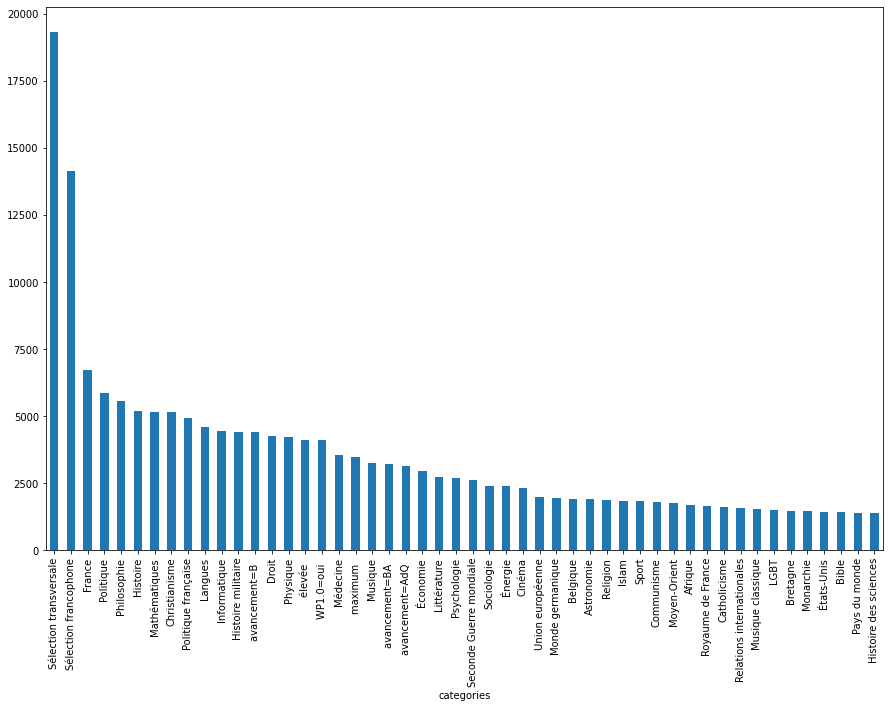

In [10]:
category_counts = df.explode('categories').value_counts("categories")
category_counts.iloc[:50].plot.bar(figsize = (15,10))

In [53]:
def remove_label(array, to_remove):
    new_arr = []
    for label in array:
        if label.strip() not in to_remove:
            new_arr.append(label)
    return new_arr
            
# Manually found outliers in top-100
# Probably legitimate labels or outliers from Spark
outliers = [
    "avancement=B", "avancement=AdQ", "WP1.0=oui", 
    "avancement=BA", "avancement=A", "élevée", "maximum",
    "moyenne"
]

# Too frequent
too_freq = ["Sélection transversale", "Sélection francophone"]
to_remove = outliers + too_freq

df["categories"] = df.categories.apply(remove_label, args = (to_remove, ))

# Filter again after removing labels
df = df.loc[df.categories.apply(len) > 0]

# Filter too short texts
df = df.loc[df.text.apply(len) > 50]

df.head()

,text,categories
0,j'ai du lui en donner 4 ou 5. Je lui ai donné ...,"[Metal, Rock, Musique, Norvège]"
1,Que de temps pour trouver \ Dmitri/Dmitry/Dim...,"[Culture russe, Russie, Musique classique, URSS]"
2,"c'est toujours la forme \ îles \"" sans majus...","[Pays du monde, Océanie, Îles]"
3,"qui est \ \"" '↑ a et b « During the Second Wo...","[Drapeaux, Bretagne]"
4,alors il faut revenir à l'origine de TAI (le 1...,[Astronomie]


In [54]:
def filter_labels(array, to_keep):
    new_arr = []
    for label in array:
        if label in to_keep:
            new_arr.append(label)
    if len(new_arr) < 1:
        new_arr = None
        
    return new_arr

category_counts = df \
    .explode('categories') \
    .value_counts("categories")

max_labels = 10
top_labels = category_counts.head(max_labels)

df["categories"] = df.categories.apply(filter_labels, args = (top_labels.index,))
df = df.dropna()

In [55]:
# Check for type  and empty arrays errors
errors = {}
for e in df.categories.dropna().values:
    if not isinstance(e, list):
        errors[e] = "datatype: {}".format(type(e))
    if len(e) < 1:
        errors[str(e)] = "array len < 1"
        
print("N type errors:", len(errors))

if len(errors) > 0:
    print(errors)

N type errors: 0


In [56]:
from sklearn.preprocessing import MultiLabelBinarizer

encoder = MultiLabelBinarizer()
labels_df = pd.DataFrame(encoder.fit_transform(df.categories.values))

In [57]:
from skmultilearn.model_selection import iterative_train_test_split

X_train, y_train, X_test, y_test = iterative_train_test_split(
    df.text.values.reshape(-1, 1),
    labels_df.values,
    test_size = 0.5
)

In [58]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# BATCH_SIZE = 256 # Big enough to measure an F1-score
BATCH_SIZE = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

train_dataset = train_dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

test_dataset = test_dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 1), (None, 10)), types: (tf.string, tf.int64)>,
 <PrefetchDataset shapes: ((None, 1), (None, 10)), types: (tf.string, tf.int64)>)

In [68]:
import tensorflow_hub as hub
from tensorflow.keras import layers

def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1


embed_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[])
embed_layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(), dtype=tf.string),
    embed_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(10, activation='sigmoid', name='output')
])

model.summary()

# Train

#LR = 1e-5 # Keep it small when transfer learning
LR = 1e-3 # Set higher value than previously presented
EPOCHS = 30

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1]
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              525312    
_________________________________________________________________
output (Dense)               (None, 10)                10250     
Total params: 257,333,386
Trainable params: 535,562
Non-trainable params: 256,797,824
_________________________________________________________________
Epoch 1/30
66/66 [==============================] - 33s 476ms/step - loss: 0.7880 - macro_f1: 0.2244 - val_loss: 0.6985 - val_macro_f1: 0.3543
Epoch 2/30
66/66 [==============================] - 33s 511ms/step - loss: 0.6718 - macro_f1: 0.3685 - val_loss: 0.6305 - val_macro_f1: 0.3892
Epoch 3/30
66/66 [==============================] - 34s 522ms/step - loss: 0.6

<AxesSubplot:>

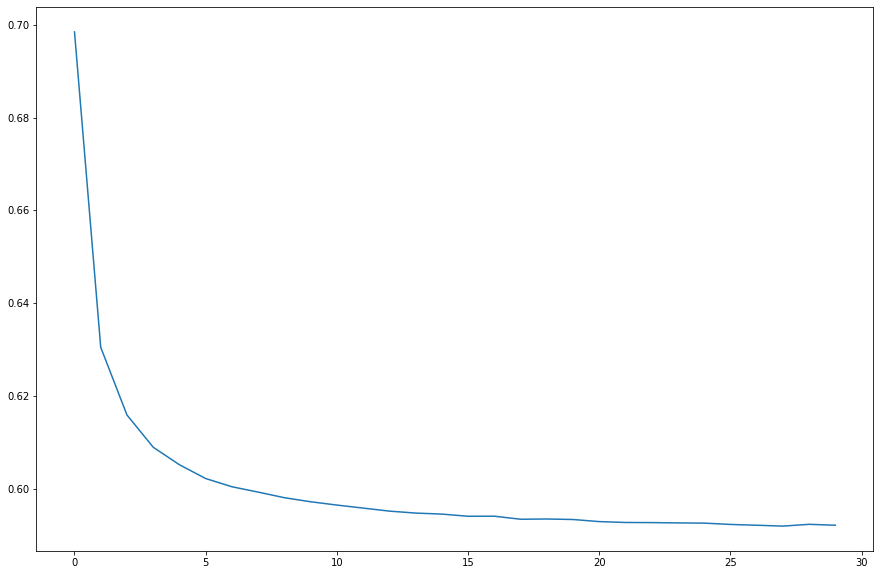

In [69]:
pd.Series(history.history['val_loss']).plot(figsize = (15, 10))

In [95]:
sentence = "les ventes de ps5 sont faibles"
preds = model.predict([sentence])


preds = [1 if x.item() > 0.5 else 0 for x in preds[0]]
encoder.inverse_transform(np.array([preds]))[0]

('Informatique',)

In [119]:
sentences = [
    "t'es de gauche ?",
    "a ta gauche",
    "les ventes de ps5 sont faibles",
    "vive la france",
    "c de la gelée rempli d'une melasse de neuronne xD",
    "La culture c'est de la conaissance , pas de l'intelligence",
    """
    Imagine une personne est Curieuse uniquement sur un domaine, Il connait a mort son domaine,
    mais que celui-ci, du coup il n'est pas intelligent ? @Etoiles
    """,
    "ce genre de live chill quel plaisir serieux",
    """Il y a d'autres problèmes mais la seule chose qu'on gère depuis 10 mois c'est des problèmes 
    donc vivement qu'on passe à autre chose""",
    """
    C'est comme les technologies qui te permettent de porter par exemple des choses de 200kg 
    et + comme si c'était rien à force tellement de choses seront opti
    """,
    """
    Pense tu qu'avec l'évolution de la technologie dans notre quotidien les gens arriveront à 
    dormir beaucoup moins en ressantant moins de fatigue avec les écrans et autres ?
    """,
    """
    ce que j'ai adoré pendant ce live c'est qu'il était lui même toujours passionné par ce 
    qu'il racontait en émission 
    """,
    """
    Alors si si y a des études parfaitement fiable dessus plus je l’ai expérimenté moi même 
    ça paraît bizarre mais ce n’est pas de la science fiction et beaucoup de gens l’ont expérimenté 
    à « faible niveau » d’ailleurs
    """
]

sentences = [x.strip() for x in sentences]

difficulty = 0.97
preds = model.predict(sentences)
preds = np.array([[1 if x.item() > difficulty else 0 for x in sublist] for sublist in preds])
preds = encoder.inverse_transform(np.array(preds))
preds = {sentences[i] : preds[i] for i, _ in enumerate(preds)}

preds = pd.DataFrame(preds.items())
preds = preds.drop(preds.loc[preds[1] == ()].index)
preds

,0,1
0,t'es de gauche ?,"(Politique,)"
2,les ventes de ps5 sont faibles,"(Informatique,)"
3,vive la france,"(France, Histoire)"
5,"La culture c'est de la conaissance , pas de l'...","(France, Histoire)"
9,C'est comme les technologies qui te permettent...,"(Informatique, Physique)"
10,Pense tu qu'avec l'évolution de la technologie...,"(Informatique,)"
12,Alors si si y a des études parfaitement fiable...,"(Philosophie,)"


In [128]:
output_dir = "../tf_model/frwikipedia_10_categories_classifier"
model.save(output_dir)

INFO:tensorflow:Assets written to: ../tf_model/frwikipedia_10_categories_classifier/assets


INFO:tensorflow:Assets written to: ../tf_model/frwikipedia_10_categories_classifier/assets


In [129]:
! ls ../tf_model

frwikipedia_10_categories_classifier


### NOTES :

* Difficulty : set to very high (0.97) to filter "null" sentences
* rename final model to specify discussion data from revisions
* Move most of data preprocessing to Spark to use whole dataset instead of 500000 samples